In [1]:
# %load_ext autoreload
# %autoreload 2
%pylab
%matplotlib notebook

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn.functional as F
import torchvision
import dipmodel
from PIL import Image
import tqdm
import math
from IPython import display

In [3]:
torch.cuda.set_device(2)

### Setup Functions

In [4]:
def totensor(img):
    t = torch.from_numpy(asarray(img)).permute(2,0,1)[None, ...]
    t = t.float() / 255.
    return t

def todisp(img):
    return img.detach().squeeze(0).permute(1, 2, 0).cpu().numpy()

def add_noise(z, i, std=0.02):
    noise = torch.normal(0.0, std * math.log10(i+1), z.shape).cuda()
    return z + noise

In [5]:
class OneCycleLR(object):
    def __init__(self, total, min, max):
        self.n = total
        self.min = min
        self.max = max
        
    def update(self, optim, i):
        '''Linear one-cycle update'''
        n = self.n
        s, e = self.min, self.max
        d = e - s
        k = n // 3
        m1, b1 = d / k, s
        m2, b2 = -e / (n - k), (s * k + e * n) / (n - k)
        lr = min(m1*i + b1, m2*i + b2)
        if optim is not None:
            optim.param_groups[0]['lr'] = lr
        return lr

class ConstantLR(object):
    def __init__(self, lr):
        self.lr = lr

    def update(self, optim, i):
        if optim is not None:
            lr.param_groups[0]['lr'] = self.lr
        return self.lr

In [6]:
def setup(img, size=448, norm='batch'):
    tens = (torchvision.transforms.functional
            .to_tensor(img.resize((size, size), Image.BILINEAR))
            .cuda())[None, ...]
    z = torch.rand(1, 32, size, size).cuda() * 0.1 - 0.05

    model = dipmodel.dip(norm=norm).cuda()
    return model, tens, z

def train_dip(model, img_tensor, z, iters=2000, lr='one-cycle', clear_pb=False):
    if lr == 'one-cycle':
        schedule = OneCycleLR(iters, 1e-5, 1e-2)
    elif lr == 'constant':
        schedule = ConstantLR(1e-3)
    else:
        schedule = lr
    loss_fn = torch.nn.MSELoss()
    optim = torch.optim.Adam(model.parameters(), lr=1e-2)
    losses = []
    IT = tqdm.tqdm_notebook(range(iters), leave=not clear_pb)
    for i in IT:
        schedule.update(optim, i)
        optim.zero_grad()
        xhat = model(add_noise(z, i))
        loss = loss_fn(xhat, img_tensor)
        losses.append(loss.item())
        loss.backward()
        optim.step()
        IT.set_postfix_str(str(losses[-1]))
    return xhat, losses

In [7]:
def fax(r, c, figsize=(5, 5)):
    return subplots(1, 2, figsize=figsize, constrained_layout=True)

### Test Images

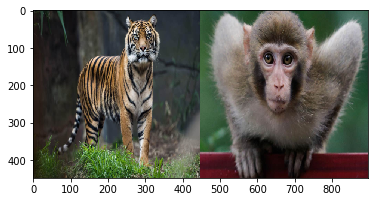

In [8]:
tiger = Image.open('images/tiger.jpg').convert('RGB')
monkey = Image.open('images/monkey.jpg').convert('RGB')
tiger = tiger.resize((448, 448), Image.BILINEAR)
monkey = monkey.resize((448, 448), Image.BILINEAR)
imshow(np.concatenate((tiger, monkey), 1))

# Noise Impedence Test

This is meant to reproduce the results from `Figure 2` in [Deep Image Prior](https://arxiv.org/abs/1711.10925). This is a check to make sure that deep image priors seem to be working for me like they should.

In [9]:
iters = 5000
size = 448

### Natural Image

In [10]:
model, natural_image, z = setup(monkey)
result, losses_nat = train_dip(model, natural_image, z, iters=iters)

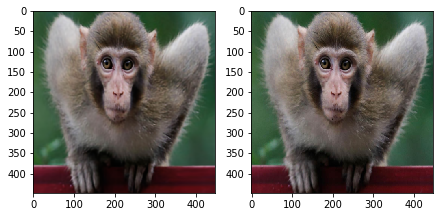

In [11]:
fig, ax = fax(1, 2, (6, 3))
ax[0].imshow(todisp(result))
ax[1].imshow(todisp(natural_image))

### Image + Noise

In [12]:
model, contaminated_image, z = setup(monkey)
contaminated_image += torch.normal(0, 0.5/4, (3, size, size)).cuda()
contaminated_image.clamp(0, 1)
result, losses_con = train_dip(model, contaminated_image, z, iters=iters)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


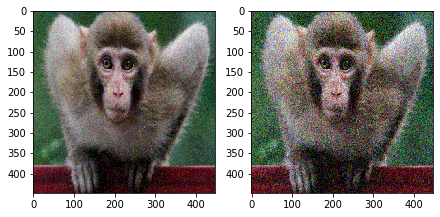

In [13]:
fig, ax = fax(1, 2, (6, 3))
ax[0].imshow(todisp(result))
ax[1].imshow(todisp(contaminated_image))

### Uniform Noise

In [14]:
unoise_img = torch.rand(1, 3, size, size).cuda()
z = torch.rand(1, 32, size, size).cuda() * 0.1 - 0.05
model = dipmodel.dip().cuda()

result, losses_unoise = train_dip(model, unoise_img, z, iters=iters)

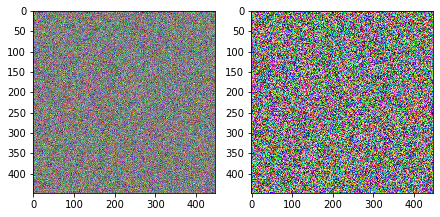

In [15]:
fig, ax = fax(1, 2, (6, 3))
ax[0].imshow(todisp(result))
ax[1].imshow(todisp(unoise_img))

### Gaussian Noise

In [16]:
nnoise_img = torch.normal(0.5, 0.5/4, (1, 3, size, size)).cuda()
z = torch.rand(1, 32, size, size).cuda() * 0.1 - 0.05
model = dipmodel.dip().cuda()

result, losses_nnoise = train_dip(model, nnoise_img, z, iters=iters)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


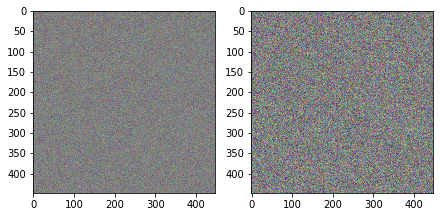

In [17]:
fig, ax = fax(1, 2, (6, 3))
ax[0].imshow(todisp(result))
ax[1].imshow(todisp(nnoise_img))

### Loss Comparison

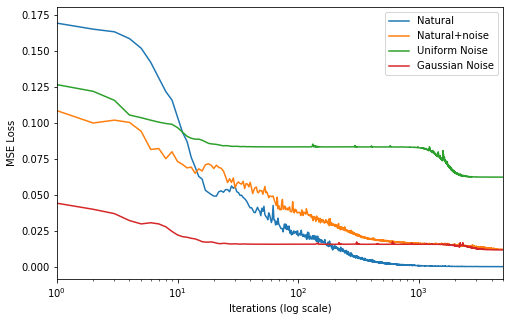

In [18]:
fig, ax = subplots(1, 1, figsize=(8, 5))
ax.semilogx(losses_nat, label='Natural')
ax.semilogx(losses_con, label='Natural+noise')
ax.semilogx(losses_unoise, label='Uniform Noise')
ax.semilogx(losses_nnoise, label='Gaussian Noise')
ax.legend()
ax.set_ylabel('MSE Loss')
ax.set_xlabel('Iterations (log scale)')
ax.set_xlim(1, 5000)
pass

The results shown in the above graph more or less follow the trend from `Figure 2` in the original Deep Image Prior paper. I do find it a little strange that the natural image starts with the highest loss, and the noise image starts with the lowest. That is not what is shown in the original paper.

I also experimented with both Gaussian and Uniform noise. Uniform noise is significantly harder to learn. It could be that Gaussian noise is easier to learn because the network weights are initialized from a Gaussian distribution, making the fit more natural?

# Single DIP Textures

The objective of this section is to reproduce the results shown in `Figure 3`, where a blended texture is harder for a DIP to fit than the single textures that it is composed of.

## Single DIP Texture Image Blends

In [19]:
def open_resize(x):
    x = Image.open(x).convert('RGB')
    w, h = x.size
    f = size / min(w, h)
    w, h = int(f * w), int(f * h)
    x = x.resize((w, h), Image.BILINEAR)
    return x

textures = list(Path('images/textures/').glob('*.jpg'))
textures = [open_resize(x).crop((0,0,size,size)) for x in textures]

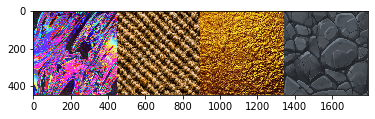

In [20]:
imshow(np.concatenate(textures, 1))

In [21]:
single_texture_losses = []
for i in range(len(textures)):
    model, tens, z = setup(textures[i], size=320)
    res, loss = train_dip(model, tens, z, iters=500, lr=OneCycleLR(500, 5e-5, 3e-3))
    single_texture_losses.append(loss)

In [36]:
multi_texture_losses = []
for i in range(len(textures)-1):
    for j in range(i + 1, len(textures)):
        mix = Image.blend(textures[i], textures[j], 0.5)
        model, tens, z = setup(mix, size=320)
        res, loss = train_dip(model, tens, z, iters=500, lr=OneCycleLR(500, 5e-5, 3e-3), clear_pb=True)
        multi_texture_losses.append(loss)

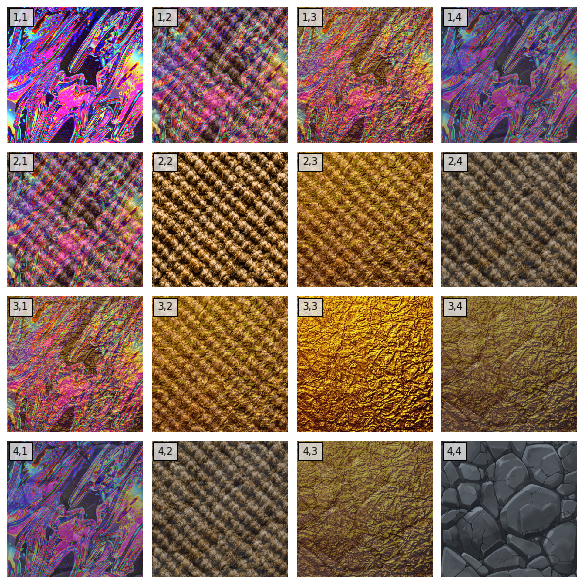

In [47]:
fig, ax = subplots(4, 4, figsize=(8, 8), constrained_layout=True)
for i in range(len(textures)):
    for j in range(len(textures)):
        ax[i, j].imshow(Image.blend(textures[i], textures[j], 0.5))
        ax[i, j].text(.04, .96, f'{i+1},{j+1}', ha='left', va='top',
                      transform=ax[i,j].transAxes,
                      bbox=dict(fc=(.9,.9,.9,.8)))
        ax[i, j].axis('off')

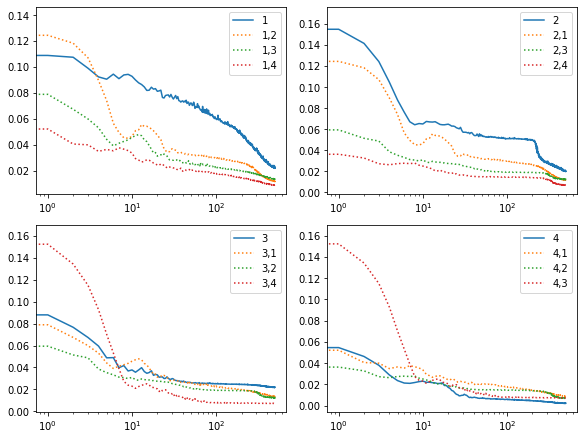

In [43]:
fig, ax = subplots(2, 2, figsize=(8, 6), constrained_layout=True)
ax = ax.flatten()
for i, l in enumerate(single_texture_losses):
    ax[i].semilogx(l, label=(i+1))
cc = [[i,j] for i in range(4) for j in range(i+1, 4)]
for i, l in enumerate(multi_texture_losses):
    ax[cc[i][0]].semilogx(l, linestyle=':', label=f'{cc[i][0]+1},{cc[i][1]+1}')
    ax[cc[i][1]].semilogx(l, linestyle=':', label=f'{cc[i][1]+1},{cc[i][0]+1}')
for a in ax.ravel(): a.legend()

## Single DIP Natural Image Blends

### BSDS300

In [24]:
path = Path('/multiview/datasets/BSDS300/images/train')
img_files = list(path.glob('*.jpg'))
single_losses = []
for imf in tqdm.tqdm_notebook(img_files[:100]):
    img = Image.open(imf).convert('RGB')
    model, tens, z = setup(img, size=320)
    _, loss = train_dip(model, tens, z, iters=500, clear_pb=True)
    single_losses.append(loss)

In [25]:
blend_losses = []
for i in tqdm.tqdm_notebook(range(100)):
    img1 = Image.open(img_files[i]).convert('RGB').resize((size, size), Image.BILINEAR)
    idx = np.random.choice(100, 2, replace=False)
    idx = idx[0] if idx[0] != i else idx[1]
    img2 = Image.open(img_files[idx]).convert('RGB').resize((size, size), Image.BILINEAR)
    img = Image.blend(img1, img2, 0.5)
    model, tens, z = setup(img, size=320)
    _, loss = train_dip(model, tens, z, iters=500, clear_pb=True)
    blend_losses.append(loss)

In [26]:
single_losses = np.array(single_losses)
blend_losses = np.array(blend_losses)

In [27]:
np.savez('bsds300_natural_blending.npz', single=single_losses, blend=blend_losses)

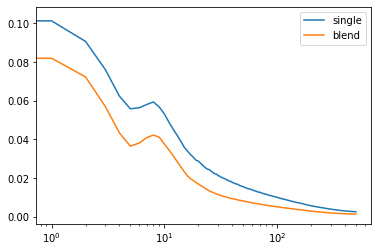

In [37]:
semilogx(np.mean(single_losses, axis=0), label='single')
semilogx(np.mean(blend_losses, axis=0), label='blend')
legend()
pass

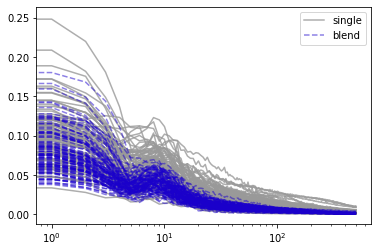

In [29]:
semilogx(single_losses.T, color=(.6,.6,.6,.8), label='single')
semilogx(blend_losses.T, color=(0.1, 0.0, 0.8, 0.5), linestyle='--', label='blend')
hs, lbs = gca().get_legend_handles_labels()
legend([hs[0], hs[-1]], [lbs[0], lbs[-1]])
pass

## Conclusions

I am not able to reproduce the results in Section 2 of the paper, where they show that image blends are harder for a DIP to learn than the individual components. I tested both textures and natural images, and found the opposite to be true: on average, the loss is lower for the blends. There were a few exeptions, but they appear to be exceptions rather than the rule. I'm not sure why results are so different from those reported in the paper.